In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/skin-cancer-melanoma/melanoma_cancer_dataset/test/benign/melanoma_9697.jpg
/kaggle/input/skin-cancer-melanoma/melanoma_cancer_dataset/test/benign/melanoma_10087.jpg
/kaggle/input/skin-cancer-melanoma/melanoma_cancer_dataset/test/benign/melanoma_9618.jpg
/kaggle/input/skin-cancer-melanoma/melanoma_cancer_dataset/test/benign/melanoma_9614.jpg
/kaggle/input/skin-cancer-melanoma/melanoma_cancer_dataset/test/benign/melanoma_9862.jpg
/kaggle/input/skin-cancer-melanoma/melanoma_cancer_dataset/test/benign/melanoma_9838.jpg
/kaggle/input/skin-cancer-melanoma/melanoma_cancer_dataset/test/benign/melanoma_9851.jpg
/kaggle/input/skin-cancer-melanoma/melanoma_cancer_dataset/test/benign/melanoma_9691.jpg
/kaggle/input/skin-cancer-melanoma/melanoma_cancer_dataset/test/benign/melanoma_10011.jpg
/kaggle/input/skin-cancer-melanoma/melanoma_cancer_dataset/test/benign/melanoma_9785.jpg
/kaggle/input/skin-cancer-melanoma/melanoma_cancer_dataset/test/benign/melanoma_9882.jpg
/kaggle/input/skin-

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from transformers import ViTModel
import timm

# Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data Transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [3]:
# Dataset Paths
train_data_path = '/kaggle/input/skin-cancer-melanoma/melanoma_cancer_dataset/train'
test_data_path = '/kaggle/input/skin-cancer-melanoma/melanoma_cancer_dataset/test'

# Load Data
train_dataset = datasets.ImageFolder(root=train_data_path, transform=data_transforms['train'])
test_dataset = datasets.ImageFolder(root=test_data_path, transform=data_transforms['test'])

# Dataloaders
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

****CNN + GRU + VIT Self Attention Mechanism****

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, GRU, Dense, Dropout, 
                                     Flatten, LayerNormalization, MultiHeadAttention)
from tensorflow.keras.layers import GlobalAveragePooling2D, Reshape, Add
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

# ✅ Image Size and Batch Size
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# ✅ Data Augmentation for Training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

# ✅ Load Data
train_generator = train_datagen.flow_from_directory(
    '/kaggle/input/skin-cancer-melanoma/melanoma_cancer_dataset/train',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    '/kaggle/input/skin-cancer-melanoma/melanoma_cancer_dataset/test',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

# ✅ Handle Class Imbalance
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(train_generator.classes),
                                     y=train_generator.classes)
class_weights_dict = dict(enumerate(class_weights))


Found 9605 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [3]:
# ✅ Vision Transformer (ViT) Encoder Block
def vit_encoder(x, num_heads=4, key_dim=32):
    """ Vision Transformer Encoder Block """
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(x, x)
    x = Add()([x, attn_output])  # Residual Connection
    x = LayerNormalization()(x)

    ff = Dense(128, activation='relu')(x)
    ff = Dense(128)(ff)
    x = Add()([x, ff])  # Residual Connection
    x = LayerNormalization()(x)

    return x

In [5]:
# ✅ CNN + GRU + ViT Self-Attention Model
def create_model():
    inputs = Input(shape=(224, 224, 3))

    # ✅ CNN Feature Extractor
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    # ✅ Global Average Pooling instead of Flatten
    x = GlobalAveragePooling2D()(x)

    # ✅ Reshape for GRU
    x = Reshape((1, -1))(x)

    # ✅ GRU Layer
    x = GRU(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.3)(x)

    # ✅ Vision Transformer Self-Attention
    x = vit_encoder(x)

    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)


    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs, outputs)

    # ✅ Compile the Model with AdamW
    model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-4),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

# ✅ Create Model
optimized_model = create_model()
optimized_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 224, 224, 32)   │            896 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 112, 112, 32)   │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 112, 112, 64)   │         18,496 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 56, 56, 64)     │              0 │ conv2d_4[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 56, 56, 128)    │         73,856 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5           │ (None, 28, 28, 128)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 128)            │              0 │ max_pooling2d_5[0][0]  │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_1 (Reshape)       │ (None, 1, 128)         │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gru_1 (GRU)               │ (None, 1, 128)         │         99,072 │ reshape_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_1    │ (None, 1, 128)         │         66,048 │ gru_1[0][0],           │
│ (MultiHeadAttention)      │                        │                │ gru_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 1, 128)         │              0 │ gru_1[0][0],           │
│                           │                        │                │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_2     │ (None, 1, 128)         │            256 │ add_2[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 1, 128)         │         16,512 │ layer_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 1, 128)         │         16,512 │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_3 (Add)          

 Total params: 308,545 (1.18 MB)

 Trainable params: 308,545 (1.18 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# ✅ Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)
]

# ✅ Train the Model
history = optimized_model.fit(train_generator,
                              epochs=25,
                              validation_data=test_generator,
                              callbacks=callbacks,
                              class_weight=class_weights_dict)

Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


301/301 ━━━━━━━━━━━━━━━━━━━━ 146s 441ms/step - accuracy: 0.5918 - loss: 0.6862 - val_accuracy: 0.8200 - val_loss: 0.3979 - learning_rate: 1.0000e-04
Epoch 2/25
301/301 ━━━━━━━━━━━━━━━━━━━━ 110s 358ms/step - accuracy: 0.7477 - loss: 0.5202 - val_accuracy: 0.8330 - val_loss: 0.3740 - learning_rate: 1.0000e-04
Epoch 3/25
301/301 ━━━━━━━━━━━━━━━━━━━━ 112s 363ms/step - accuracy: 0.7774 - loss: 0.4792 - val_accuracy: 0.8510 - val_loss: 0.3434 - learning_rate: 1.0000e-04
Epoch 4/25
301/301 ━━━━━━━━━━━━━━━━━━━━ 111s 360ms/step - accuracy: 0.8015 - loss: 0.4407 - val_accuracy: 0.8500 - val_loss: 0.3445 - learning_rate: 1.0000e-04
Epoch 5/25
301/301 ━━━━━━━━━━━━━━━━━━━━ 110s 358ms/step - accuracy: 0.8238 - loss: 0.4090 - val_accuracy: 0.8580 - val_loss: 0.3068 - learning_rate: 1.0000e-04
Epoch 6/25
301/301 ━━━━━━━━━━━━━━━━━━━━ 110s 356ms/step - accuracy: 0.8234 - loss: 0.3870 - val_accuracy: 0.8670 - val_loss: 0.2933 - learning_rate: 1.0000e-04
Epoch 7/25
301/301 ━━━━━━━━━━━━━━━━━━━━ 110s 356ms/

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.8977 - loss: 0.2601
Test Accuracy: 0.8840
 1/32 ━━━━━━━━━━━━━━━━━━━━ 14s 479ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (32, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step


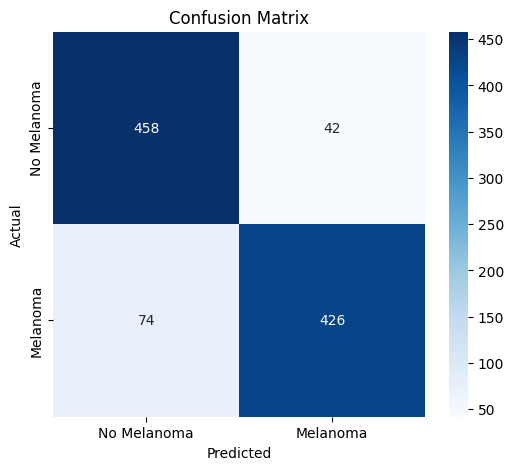

In [7]:
# ✅ Evaluate Model
test_loss, test_accuracy = optimized_model.evaluate(test_generator)
print(f'Test Accuracy: {test_accuracy:.4f}')

# ✅ Predictions & Metrics
y_true = test_generator.classes
y_pred_probs = optimized_model.predict(test_generator)
y_pred_binary = (y_pred_probs > 0.5).astype(int).flatten()

# ✅ Confusion Matrix
cm = confusion_matrix(y_true, y_pred_binary)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Melanoma', 'Melanoma'], yticklabels=['No Melanoma', 'Melanoma'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

              precision    recall  f1-score   support

 No Melanoma       0.86      0.92      0.89       500
    Melanoma       0.91      0.85      0.88       500

    accuracy                           0.88      1000
   macro avg       0.89      0.88      0.88      1000
weighted avg       0.89      0.88      0.88      1000

AUC: 0.9577


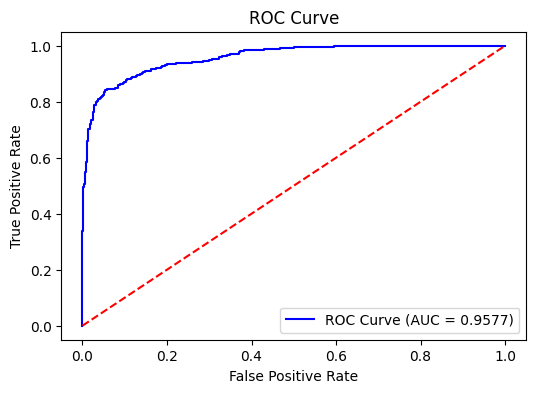

In [8]:
# ✅ Classification Report
report = classification_report(y_true, y_pred_binary, target_names=['No Melanoma', 'Melanoma'])
print(report)

# ✅ ROC Curve and AUC Score
fpr, tpr, _ = roc_curve(y_true, y_pred_probs)
roc_auc = auc(fpr, tpr)
print(f'AUC: {roc_auc:.4f}')

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})', color='blue')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

****CNN (DenseNet121) + GRU + Vision Transformer (ViT) Self-Attention****

In [7]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Reshape, LayerNormalization, MultiHeadAttention, GRU, Input, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, roc_curve, auc

# ✅ Load DenseNet121 (CNN Backbone)
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# ✅ Global Average Pooling
x = GlobalAveragePooling2D()(base_model.output)

# ✅ Reshape for GRU (batch_size, 1, feature_dim)
x = Reshape((1, -1))(x)

# ✅ GRU Layer
x = GRU(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.3)(x)

# ✅ Vision Transformer Self-Attention
x = MultiHeadAttention(num_heads=4, key_dim=64)(x, x)
x = LayerNormalization()(x)

# ✅ Flatten
x = Flatten()(x)

# ✅ Fully Connected Layer
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)

# ✅ Output Layer
outputs = Dense(1, activation='sigmoid')(x)

# ✅ Create Model
hybrid_model = Model(inputs=base_model.input, outputs=outputs)

# ✅ Compile Model
hybrid_model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# ✅ Store Models
models = [hybrid_model]  # Add other models if needed

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Found 7684 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


241/241 ━━━━━━━━━━━━━━━━━━━━ 179s 437ms/step - accuracy: 0.8436 - loss: 0.3469 - val_accuracy: 0.8250 - val_loss: 0.4027
Epoch 2/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 98s 405ms/step - accuracy: 0.9369 - loss: 0.1729 - val_accuracy: 0.7950 - val_loss: 0.4234
Epoch 3/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 98s 405ms/step - accuracy: 0.9531 - loss: 0.1212 - val_accuracy: 0.7950 - val_loss: 0.5223
Epoch 4/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 98s 405ms/step - accuracy: 0.9588 - loss: 0.1140 - val_accuracy: 0.8450 - val_loss: 0.4008
Epoch 5/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 98s 405ms/step - accuracy: 0.9642 - loss: 0.1011 - val_accuracy: 0.7950 - val_loss: 0.7982
Epoch 6/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 98s 405ms/step - accuracy: 0.9698 - loss: 0.0776 - val_accuracy: 0.8200 - val_loss: 0.4210
Epoch 7/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 98s 405ms/step - accuracy: 0.9826 - loss: 0.0528 - val_accuracy: 0.7850 - val_loss: 0.5975
Epoch 8/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 98s 405ms/step - accuracy: 0.9805 - loss: 0.0610 - va

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (32, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 693ms/step


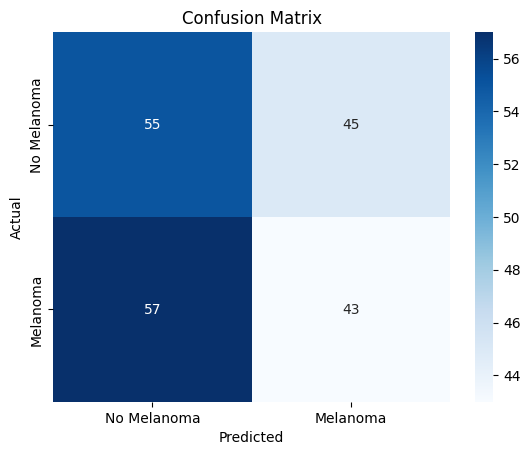

              precision    recall  f1-score   support

 No Melanoma       0.49      0.55      0.52       100
    Melanoma       0.49      0.43      0.46       100

    accuracy                           0.49       200
   macro avg       0.49      0.49      0.49       200
weighted avg       0.49      0.49      0.49       200

AUC: 0.5011


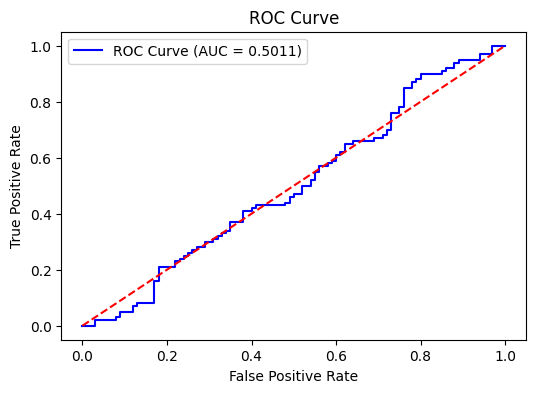

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ✅ Data Augmentation and Preprocessing
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)  # 80-20 train-validation split

train_generator = train_datagen.flow_from_directory(
    '/kaggle/input/skin-cancer-melanoma/melanoma_cancer_dataset/train',  # Replace with your dataset path
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

test_generator = train_datagen.flow_from_directory(
    '/kaggle/input/skin-cancer-melanoma/melanoma_cancer_dataset/test',  # Replace with your dataset path
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

# ✅ Train & Evaluate Optimized Model
train_and_evaluate(hybrid_model, train_generator, test_generator, epochs=10)

Training Hybrid Model 1...
Epoch 1/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 98s 405ms/step - accuracy: 0.9904 - loss: 0.0359 - val_accuracy: 0.8000 - val_loss: 0.9090
Epoch 2/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 98s 405ms/step - accuracy: 0.9924 - loss: 0.0209 - val_accuracy: 0.8450 - val_loss: 0.5981
Epoch 3/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 98s 404ms/step - accuracy: 0.9900 - loss: 0.0348 - val_accuracy: 0.8650 - val_loss: 0.4897
Epoch 4/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 98s 405ms/step - accuracy: 0.9838 - loss: 0.0462 - val_accuracy: 0.8600 - val_loss: 0.6084
Epoch 5/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 98s 405ms/step - accuracy: 0.9931 - loss: 0.0217 - val_accuracy: 0.8100 - val_loss: 0.9682
Epoch 6/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 98s 405ms/step - accuracy: 0.9959 - loss: 0.0127 - val_accuracy: 0.8550 - val_loss: 0.6294
Epoch 7/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 98s 405ms/step - accuracy: 0.9916 - loss: 0.0231 - val_accuracy: 0.8200 - val_loss: 0.7703
Epoch 8/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 98s 404ms/step -

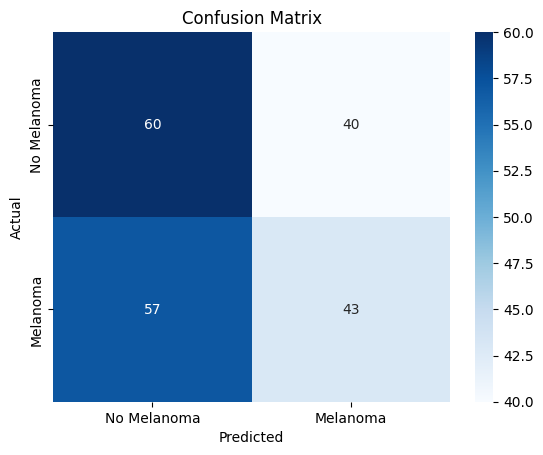

AUC: 0.5084


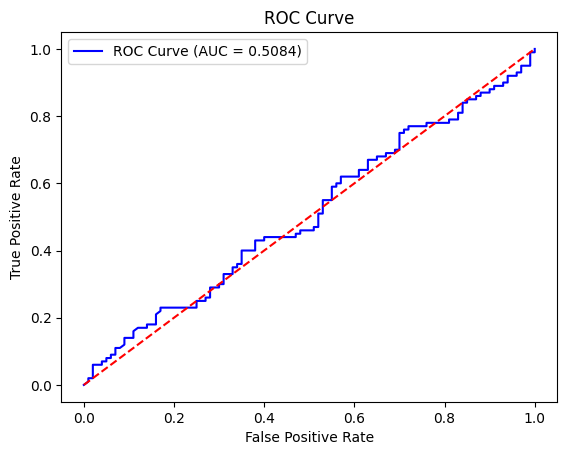

In [9]:
# ✅ Training & Evaluation Function
def train_and_evaluate(model, train_gen, test_gen, epochs=20):
    history = model.fit(train_gen, epochs=epochs, validation_data=test_gen)
    test_loss, test_accuracy = model.evaluate(test_gen)
    print(f'Test Accuracy: {test_accuracy:.4f}')
    
    # ✅ Predictions
    y_pred_probs = model.predict(test_gen)
    y_pred_binary = (y_pred_probs > 0.5).astype(int)

    # ✅ Confusion Matrix
    cm = confusion_matrix(test_gen.classes, y_pred_binary)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Melanoma', 'Melanoma'], yticklabels=['No Melanoma', 'Melanoma'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    # ✅ ROC Curve
    fpr, tpr, _ = roc_curve(test_gen.classes, y_pred_probs)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})', color='blue')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

# ✅ Train and Evaluate Hybrid Model
for i, model in enumerate(models):
    print(f"Training Hybrid Model {i+1}...")
    train_and_evaluate(model, train_generator, test_generator, epochs=20)